<a href="https://colab.research.google.com/github/melodch/TexturesML/blob/main/MLTexturesProject1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project 1:
Textures**

Things to tweak:
**Simrun**
- Epox
- Learning rate
- Kernal size
- Crop size( cropping at 300 makes the image cut quite a bit but changing that number makes it so that there are black edges)
- Add normalization layers

**Melody**
- Learning Rate
- Shuffle before and during training
- Training-testing ratio
- Number of NN layers
- Data augmentation
---

In [1]:
!pip install torchviz
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchviz import make_dot
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from google.colab.patches import cv2_imshow
import glob
import os
import cv2
import random
import shutil
import time
from PIL import Image

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=2bee914f5ec1779e53be898b98f284f3556926fd3f41763c9cafaece348419bb
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
!unzip /content/drive/MyDrive/images.zip

In [4]:
# Create training and testing folders
test_path = "/content/test_images"
train_path = "/content/train_images"
try:
  os.mkdir(test_path)
  os.mkdir(train_path)
  print("Created testing and training image folders")
except:
  print("Testing and training image folders already exist")

Created testing and training image folders


In [ ]:
# Blow up images
def resize_image(im):
  width, height = im.size
  if width < 400 or height < 400:            
    im = im.resize((int(width*1.2), int(height*1.2)))            
    if width < 400 or height< 400:            
      im = im.resize((int(width*1.2), int(height*1.2))) 
      if width < 400 or height:
        im = im.resize((int(width*1.2), int(height*1.2))) 
  return im

directory = "/content/images/"
# Resize images
for images_path in glob.glob("images"):
  for folder_path in glob.glob(os.path.join(images_path, '*')):
      for file_path in glob.glob(os.path.join(folder_path, '*.jpg')):        
        file_list = file_path.split("/")
        foldername = file_list[1]
        filename = file_list[2]
        im = Image.open(file_path)
        if im is not None:
            im = resize_image(im)
            save_filename = "/content/" + file_path
            print(save_filename)
            im.save(save_filename)

In [6]:
# Create augmented images, add to main images folder
for images_path in glob.glob('images'):
  for folder_path in glob.glob(os.path.join(images_path, 'c*')):
    img_paths = glob.glob(os.path.join(folder_path, '*.jpg')) # Get all images in this texture folder
    for image in img_paths:
      original_img = Image.open(image)
      # Flip the original image vertically
      vertical_img = original_img.transpose(method=Image.FLIP_TOP_BOTTOM)
      vertical_img.save(image[:-4] + '_v_flipped.jpg')
      # Flip the original image horizontally
      horizontal_img = original_img.transpose(method=Image.FLIP_LEFT_RIGHT)
      horizontal_img.save(image[:-4] + '_h_flipped.jpg')
      # Rotate the original image by 90 degrees
      rotated_img = original_img.rotate(90, resample=0, expand=1)
      rotated_img.save(image[:-4] + '_rotated.jpg')
      # close all our files object
      original_img.close()
      vertical_img.close()
      horizontal_img.close()
      rotated_img.close()

In [7]:
# Divide up main images folder into training and testing
training_testing_split = 0.7  # No. here is % of data that will be in training set
train_images = []
test_images = []
train_labels = []
test_labels = []
classes = []
for images_path in glob.glob('/content/images'):
  for folder_path in glob.glob(os.path.join(images_path, 'c*')):
    img_paths = glob.glob(os.path.join(folder_path, '*.jpg')) # Get all images in this texture folder
    num_train = int(len(img_paths)*training_testing_split)    # Get train-test split point

    # Add textures to class list
    path_list = folder_path.split("/")
    classes.append(path_list[-1])

    # Split data
    random.shuffle(img_paths)
    train_data = img_paths[:num_train]
    test_data = img_paths[num_train:]

    # Get texture label
    extracted_tags = folder_path.split("/")
    texture_label = extracted_tags[3]

    train_texture_folder = train_path + "/" + texture_label
    test_texture_folder = test_path + "/" + texture_label
    try:
      os.mkdir(train_texture_folder)
      os.mkdir(test_texture_folder)
      print("Creating testing and training texture folder: " + texture_label)
    except:
      print("Testing and training texture: " + texture_label + " folder already exists")

    # Load train and test data into respective arrays
    for file_path in train_data:
      shutil.copy(file_path, train_texture_folder)
    for file_path in test_data:
      shutil.copy(file_path, test_texture_folder)

Creating testing and training texture folder: chequered
Creating testing and training texture folder: cracked
Creating testing and training texture folder: crystalline
Creating testing and training texture folder: cobwebbed
Creating testing and training texture folder: crosshatched


In [8]:
# Comment 0: define transformation that you wish to apply on image
data_transforms = transforms.Compose([
                    transforms.CenterCrop(300),
                    transforms.ToTensor()])

# Comment 1 : Load the datasets with ImageFolder
image_datasets = ImageFolder(root= "/content/images/", transform=data_transforms)
# train dataset
train_image_datasets = ImageFolder(root= "/content/train_images/", transform=data_transforms)
# test dataset
test_image_datasets = ImageFolder(root= "/content/test_images/", transform=data_transforms)

In [69]:
# images = []
# for i in range(500):
  
#   image = train_image_datasets[i]
#   tensor_image = image[0]
#   if i % 10 == 0:
#     plt.imshow(tensor_image.permute(1, 2, 0))
#     plt.show()
#   images.append(image[0])
# for image in images:
#   cv2_imshow(image)



Neural Networks




In [9]:
class MyCNN(nn.Module):
    # The init funciton in Pytorch classes is used to keep track of the parameters of the model
    # specifically the ones we want to update with gradient descent + backprop
    # So we need to make sure we keep track of all of them here
    def __init__(self):
        super(MyCNN, self).__init__()
        # layers defined here
        num_kernels = 8
        #applying a 2d convolution
        self.conv1 = nn.Conv2d(image_dims[0], num_kernels, kernel_size=3, stride=1, padding=1)
       
        # puts pixel values into groups and then selects the maximum out of the groups eg 4, 5 , 2 6 will become just 6
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # maxpool_output_size is the total amount of data coming out of that
        # layer.  
        # code below computes this quantity.
        self.maxpool_output_size = int(num_kernels * (image_dims[1] / 2) * (image_dims[2] / 2))

        # adding batch normalization
        # self.bn = nn.BatchNorm2d(num_kernels)

        # Add on a fully connected layer (like in our MLP)
        # fc stands for fully connected
        fc1_size = 64
        self.fc1 = nn.Linear(self.maxpool_output_size, fc1_size)

        # we'll use this activation function internally in the network
        self.activation_func = torch.nn.ReLU()

        # Convert our fully connected layer into outputs that we can compare to the result
        fc2_size = len(glob.glob(os.path.join('/content/images', '*')))
        self.fc2 = nn.Linear(fc1_size, fc2_size)

        
    # The forward function in the class defines the operations performed on a given input to the model
    # and returns the output of the model
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.activation_func(x)
        # x = self.bn(x)
        # this code flattens the output of the convolution, max pool,
        # activation sequence of steps into a vector
        x = x.view(-1, self.maxpool_output_size)
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        return x

    # The loss function (which we chose to include as a method of the class, but doesn't need to be)
    # returns the loss and optimizer used by the model
    def get_loss(self, learning_rate):
      # Loss function
      loss = nn.CrossEntropyLoss()
      # Optimizer, self.parameters() returns all the Pytorch operations that are attributes of the class
      optimizer = optim.Adam(self.parameters(), lr=learning_rate)
      return loss, optimizer

In [31]:
# Define training parameters
batch_size = 30
learning_rate = 1e-5 #1e-2
n_epochs = 40
# Dataset paremeters
image_dims = 3, 300, 300

# Get our data into the mini batch size that we defined
train_loader = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size,
                                            num_workers=2, shuffle = True)
test_loader = torch.utils.data.DataLoader(
    test_image_datasets, batch_size=300, num_workers=2, shuffle = True)

def train_model(net):
    """ Train a the specified network.

        Outputs a tuple with the following four elements
        train_hist_x: the x-values (batch number) that the training set was 
            evaluated on.
        train_loss_hist: the loss values for the training set corresponding to
            the batch numbers returned in train_hist_x
        test_hist_x: the x-values (batch number) that the test set was 
            evaluated on.
        test_loss_hist: the loss values for the test set corresponding to
            the batch numbers returned in test_hist_x
    """ 
    loss, optimizer = net.get_loss(learning_rate)
    # Define some parameters to keep track of metrics
    print_every = 20
    idx = 0
    train_hist_x = []
    train_loss_hist = []
    test_hist_x = []
    test_loss_hist = []

    training_start_time = time.time()
    # Loop for n_epochs
    for epoch in range(n_epochs):
        running_loss = 0.0
        start_time = time.time()

        for i, data in enumerate(train_loader, 0):

            # Get inputs in right form
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
            
            # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            
            # Compute the loss and find the loss with respect to each parameter of the model
            loss_size = loss(outputs, labels)
            loss_size.backward()
            
            # Change each parameter with respect to the recently computed loss.
            optimizer.step()

            # Update statistics
            running_loss += loss_size.data.item()
            
            # Print every 20th batch of an epoch
            if (i % print_every) == print_every-1:
                print("Epoch {}, Iteration {}\t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
                # Reset running loss and time
                train_loss_hist.append(running_loss / print_every)
                train_hist_x.append(idx)
                running_loss = 0.0
                start_time = time.time()
            idx += 1

        # At the end of the epoch, do a pass on the test set
        total_test_loss = 0
        for inputs, labels in test_loader:

            # Wrap tensors in Variables
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

            # Forward pass
            test_outputs = net(inputs)
            test_loss_size = loss(test_outputs, labels)
            total_test_loss += test_loss_size.data.item()
        test_loss_hist.append(total_test_loss / len(test_loader))
        test_hist_x.append(idx)
        print("Validation loss = {:.2f}".format(
            total_test_loss / len(test_loader)))

    print("Training finished, took {:.2f}s".format(
        time.time() - training_start_time))
    return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

In [32]:
# training the network
device = 'cuda' # 'cpu' if we want to not use the gpu
net = MyCNN()
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)
train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(net)

Epoch 1, Iteration 20	 train_loss: 3.22 took: 3.83s
Epoch 1, Iteration 40	 train_loss: 2.36 took: 3.57s
Validation loss = 1.95
Epoch 2, Iteration 20	 train_loss: 1.83 took: 3.80s
Epoch 2, Iteration 40	 train_loss: 1.77 took: 3.52s
Validation loss = 1.69
Epoch 3, Iteration 20	 train_loss: 1.61 took: 3.84s
Epoch 3, Iteration 40	 train_loss: 1.61 took: 3.50s
Validation loss = 1.59
Epoch 4, Iteration 20	 train_loss: 1.53 took: 3.71s
Epoch 4, Iteration 40	 train_loss: 1.49 took: 3.55s
Validation loss = 1.54
Epoch 5, Iteration 20	 train_loss: 1.46 took: 3.70s
Epoch 5, Iteration 40	 train_loss: 1.46 took: 3.43s
Validation loss = 1.49
Epoch 6, Iteration 20	 train_loss: 1.41 took: 3.79s
Epoch 6, Iteration 40	 train_loss: 1.42 took: 3.51s
Validation loss = 1.46
Epoch 7, Iteration 20	 train_loss: 1.37 took: 3.67s
Epoch 7, Iteration 40	 train_loss: 1.40 took: 3.57s
Validation loss = 1.44
Epoch 8, Iteration 20	 train_loss: 1.33 took: 3.74s
Epoch 8, Iteration 40	 train_loss: 1.34 took: 3.44s
Validat

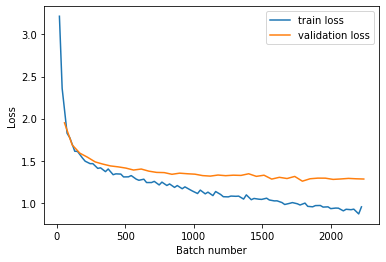

In [33]:
# plotting the outputs
plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.show()

In [34]:
def disp_image(image, class_idx, predicted):
    # need to reorder the tensor dimensions to work properly with imshow
    plt.imshow(image.transpose(0,2).transpose(0,1))
    plt.axis('off')
    # if predicted:
    plt.title("Actual: " + classes[class_idx] + "     Predicted: " + classes[predicted])
    # else:
    #     plt.title("Actual: " + classes[class_idx])
    plt.show()

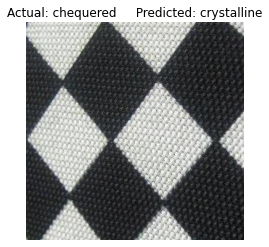

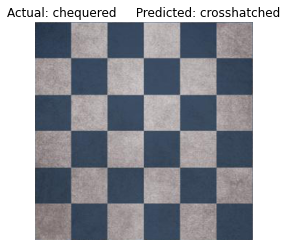

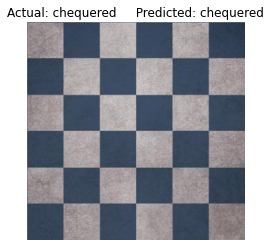

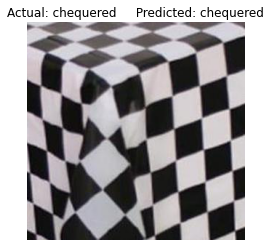

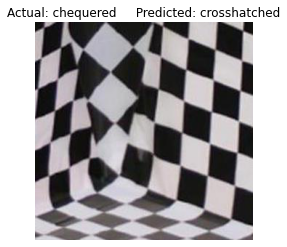

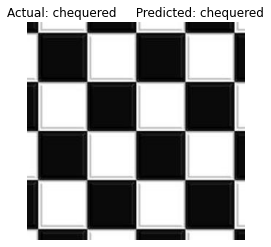

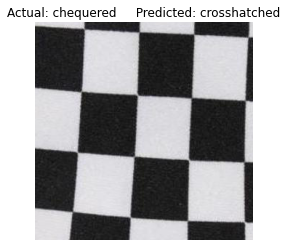

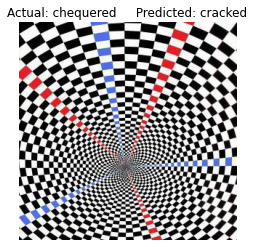

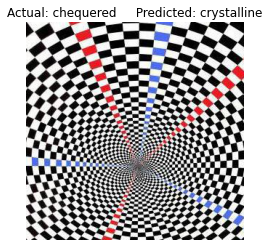

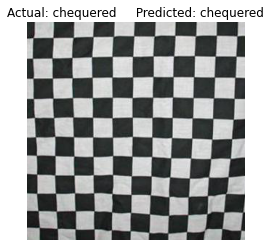

In [35]:
# Santiy-check, network prediction vs ground truth label
def examine_label(idx):
    image, label = test_image_datasets[idx]
    class_scores = net(Variable(image.unsqueeze(0)).to(device))
    prediction = np.argmax(class_scores.cpu().detach().numpy())
    # print(prediction)
    disp_image(image, label, prediction)

for i in range(40,50):
  examine_label(i)

Confusion matrix, without normalization
[[ 66   8  17   7  46]
 [  9  65  16  35  19]
 [  1  10  70  27  36]
 [  7  31  31  52  23]
 [ 14   4   7  15 104]]


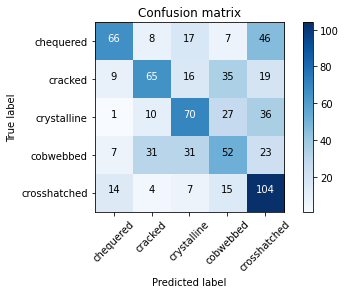

In [36]:
  from sklearn.metrics import confusion_matrix
  def make_confusion_matrix(image_dataset):
    prediction_list = []
    label_list = []
    for idx in range(len(image_dataset)):
      image, label = test_image_datasets[idx]
      class_scores = net(Variable(image.unsqueeze(0)).to(device))
      prediction = np.argmax(class_scores.cpu().detach().numpy())
      prediction_list.append(prediction)      
      label_list.append(label)
    cm = confusion_matrix(label_list, prediction_list)
    return cm

import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # disp_image(image, label, prediction)

cm = make_confusion_matrix(test_image_datasets)
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)

In [37]:
# computing accuracy
def get_accuracy(net, loader):
    n_correct = 0
    n_total = 0
    for i, data in enumerate(loader, 0):
        # Get inputs in right form
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        outputs = net(inputs)
        n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
        n_total += labels.shape[0]
    return n_correct/n_total
print("Train accuracy is", get_accuracy(net, train_loader)*100)
print("Test accuracy is", get_accuracy(net, test_loader)*100)

Train accuracy is 73.98809523809524
Test accuracy is 49.583333333333336
